<a href="https://colab.research.google.com/github/aaronmat1905/neural-noteworks/blob/renew2026/finetuningbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install -q datasets transformers torch scikit-learn matplotlib seaborn

In [ ]:
# Import libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from transformers import BertTokenizer, BertModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.64 GB


In [ ]:
# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
CONFIG = {
    # Data settings
    'SUBSET_FRACTION': 0.6,       # Use 30% of data (0.3 = fast, 1.0 = full dataset)
    'BALANCE_CLASSES': True,      # Handle class imbalance

    # Model settings
    'MAX_LENGTH': 128,             # Sequence length (64 = fast, 128 = better)
    'BATCH_SIZE': 32,             # Batch size (32 = good balance)
    'FREEZE_BERT': False,          # Freeze BERT base (True = much faster)

    # Training settings
    'LEARNING_RATE': 3e-5,        # Learning rate
    'EPOCHS': 3,                  # Number of epochs
    'DROPOUT': 0.3,               # Dropout rate

    # Optimization
    'USE_MIXED_PRECISION': True,  # Faster training
    'GRADIENT_CLIPPING': 1.0,     # Gradient clipping
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  SUBSET_FRACTION: 0.6
  BALANCE_CLASSES: True
  MAX_LENGTH: 128
  BATCH_SIZE: 32
  FREEZE_BERT: False
  LEARNING_RATE: 3e-05
  EPOCHS: 3
  DROPOUT: 0.3
  USE_MIXED_PRECISION: True
  GRADIENT_CLIPPING: 1.0


# Step 1: **Dataset Preparation**

In [ ]:
# Pulling in the Dataset from HuggingFace
dataset = load_dataset("pietrolesci/pubmed-200k-rct")

DatasetDict({
    train: Dataset({
        features: ['labels', 'text', 'uid'],
        num_rows: 2211861
    })
    validation: Dataset({
        features: ['labels', 'text', 'uid'],
        num_rows: 28932
    })
    test: Dataset({
        features: ['labels', 'text', 'uid'],
        num_rows: 29493
    })
})


In [ ]:
print(dataset)

In [ ]:
report = f"""
Train Samples: {len(dataset['train'])}
Validation Samples: {len(dataset['validation'])}
Test Samples: {len(dataset['test'])}
"""
print(report)


Train Samples: 2211861
Validation Samples: 28932
Test Samples: 29493



In [ ]:
# Bringing the Dataset to DataFrames
train_df = pd.DataFrame({
    'text': dataset['train']['text'],
    'label': dataset['train']['labels']
})

val_df = pd.DataFrame({
    'text': dataset['validation']['text'],
    'label': dataset['validation']['labels']
})

test_df = pd.DataFrame({
    'text': dataset['test']['text'],
    'label': dataset['test']['labels']
})

In [ ]:
# Using a Subset of the training data (For Faster Training)
if CONFIG['SUBSET_FRACTION'] < 1.0:
    print(f"\nUsing {CONFIG['SUBSET_FRACTION']*100}% of training data...")
    train_df = train_df.sample(
        frac=CONFIG['SUBSET_FRACTION'],
        random_state=42
    ).reset_index(drop=True)

    # Also reduce validation/test for faster evaluation
    val_df = val_df.sample(frac=0.5, random_state=42).reset_index(drop=True)
    test_df = test_df.sample(frac=0.5, random_state=42).reset_index(drop=True)

    print(f"  New train size: {len(train_df):,}")
    print(f"  New val size: {len(val_df):,}")
    print(f"  New test size: {len(test_df):,}")


Using 60.0% of training data...
  New train size: 1,327,117
  New val size: 14,466
  New test size: 14,746


# Step 2: **EDA** (Exploratory Data Analysis)

In [ ]:
# Class names
label_names = ['BACKGROUND', 'CONCLUSIONS', 'METHODS','OBJECTIVE', 'RESULTS']

In [ ]:
## Analyzing Distribution of Classes

# Count distribution BEFORE balancing
original_counts = train_df['label'].value_counts().sort_index()

print("\nOriginal Class Distribution (before balancing):")
print("="*60)
for i, name in enumerate(label_names):
    count = original_counts[i]
    percentage = (count / len(train_df)) * 100
    print(f"{name:12s}: {count:6,} ({percentage:5.2f}%)")

# Calculate imbalance ratio
max_count = original_counts.max()
min_count = original_counts.min()
imbalance_ratio = max_count / min_count
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 2:
    print("Significant class imbalance detected!")
else:
    print("Classes are relatively balanced")


Original Class Distribution (before balancing):
BACKGROUND  : 118,123 ( 8.90%)
CONCLUSIONS : 203,786 (15.36%)
METHODS     : 433,544 (32.67%)
OBJECTIVE   : 112,007 ( 8.44%)
RESULTS     : 459,657 (34.64%)

Imbalance Ratio: 4.10:1
Significant class imbalance detected!


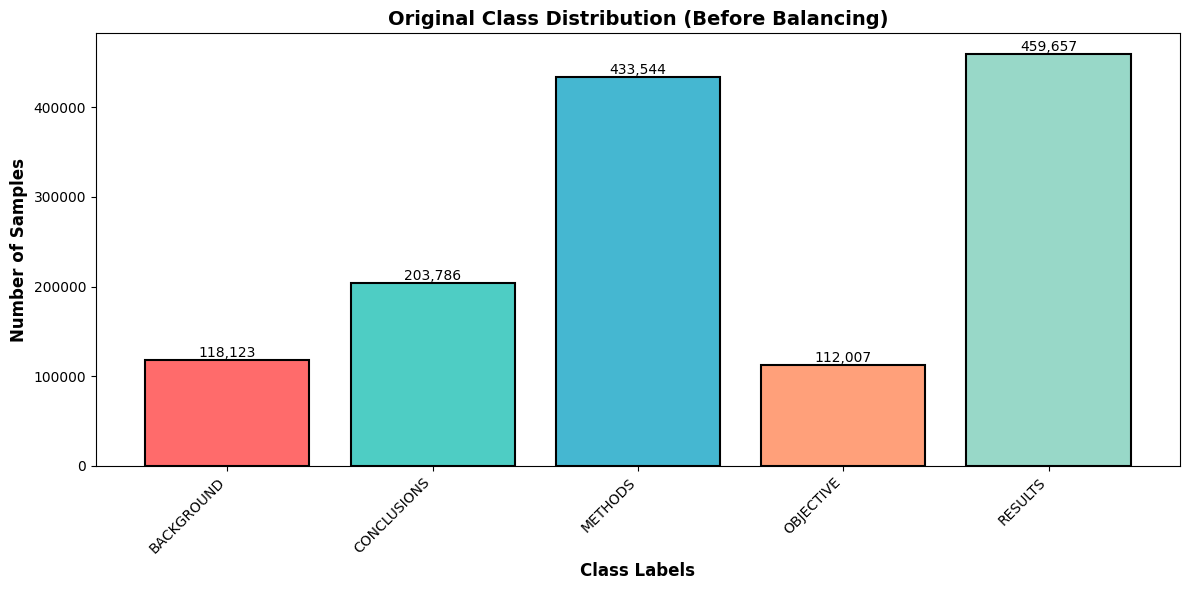

In [ ]:
# Plot original distribution
plt.figure(figsize=(12, 6))
bars = plt.bar(
    label_names,
    original_counts.values,
    color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'],
    edgecolor='black',
    linewidth=1.5
)

plt.xlabel('Class Labels', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Original Class Distribution (Before Balancing)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')

# Add count labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Balance classes using Undersampling
if CONFIG['BALANCE_CLASSES']:
    print("\nBalancing classes using undersampling...")

    # Find minimum class size
    min_class_size = train_df['label'].value_counts().min()
    print(f"  Target samples per class: {min_class_size:,}")

    # Undersample each class to minimum size
    balanced_dfs = []
    for label in range(5):
        class_df = train_df[train_df['label'] == label]

        # Undersample to min_class_size
        undersampled = resample(
            class_df,
            replace=False,
            n_samples=min_class_size,
            random_state=42
        )
        balanced_dfs.append(undersampled)

    # Combine and shuffle
    train_df = pd.concat(balanced_dfs, ignore_index=True)
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"  Balanced training size: {len(train_df):,}")

    # Show new distribution
    new_counts = train_df['label'].value_counts().sort_index()
    print("\nNew Class Distribution (after balancing):")
    print("="*60)
    for i, name in enumerate(label_names):
        count = new_counts[i]
        percentage = (count / len(train_df)) * 100
        print(f"{name:12s}: {count:6,} ({percentage:5.2f}%)")

    print("\nClasses balanced successfully!")
else:
    print("\nSkipping class balancing (CONFIG['BALANCE_CLASSES'] = False)")


Balancing classes using undersampling...
  Target samples per class: 112,007
  Balanced training size: 560,035

New Class Distribution (after balancing):
BACKGROUND  : 112,007 (20.00%)
CONCLUSIONS : 112,007 (20.00%)
METHODS     : 112,007 (20.00%)
OBJECTIVE   : 112,007 (20.00%)
RESULTS     : 112,007 (20.00%)

Classes balanced successfully!


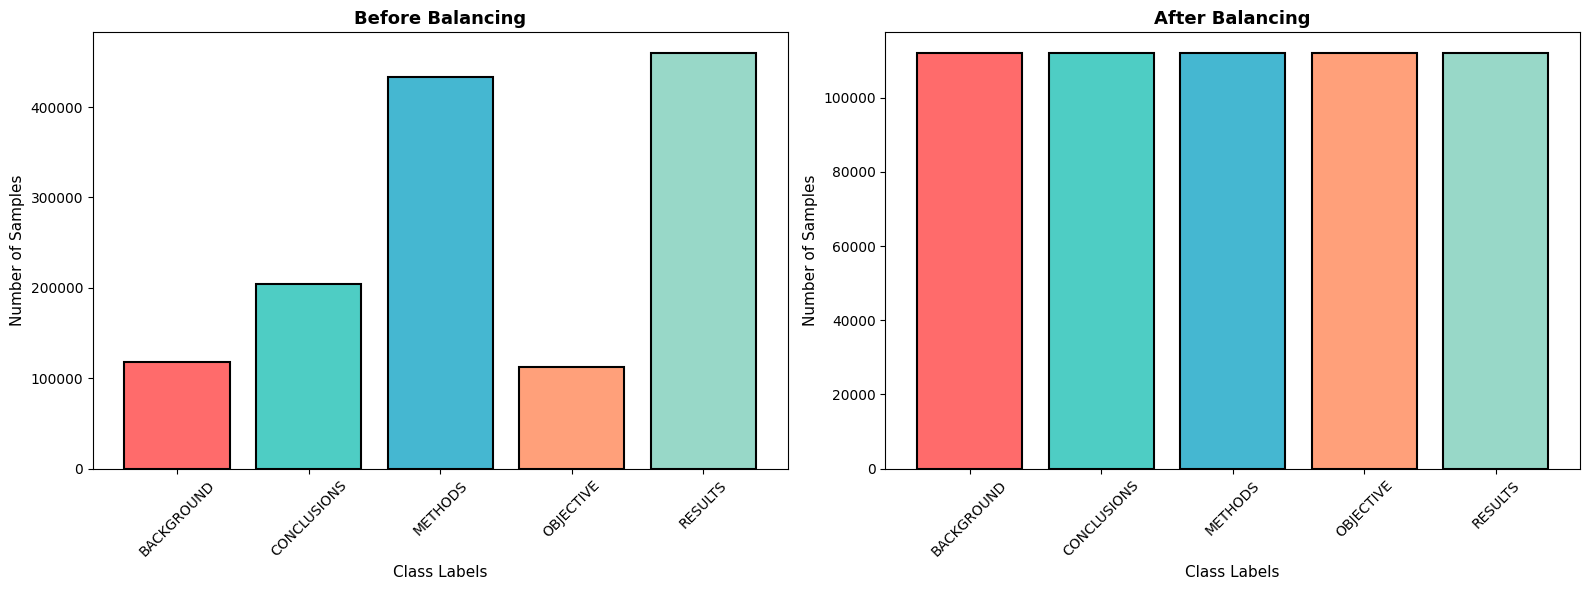

In [ ]:
# Plot balanced distribution
if CONFIG['BALANCE_CLASSES']:
    balanced_counts = train_df['label'].value_counts().sort_index()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Original distribution
    axes[0].bar(label_names, original_counts.values,
                color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'],
                edgecolor='black', linewidth=1.5)
    axes[0].set_title('Before Balancing', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Class Labels', fontsize=11)
    axes[0].set_ylabel('Number of Samples', fontsize=11)
    axes[0].tick_params(axis='x', rotation=45)

    # Balanced distribution
    axes[1].bar(label_names, balanced_counts.values,
                color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'],
                edgecolor='black', linewidth=1.5)
    axes[1].set_title('After Balancing', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Class Labels', fontsize=11)
    axes[1].set_ylabel('Number of Samples', fontsize=11)
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

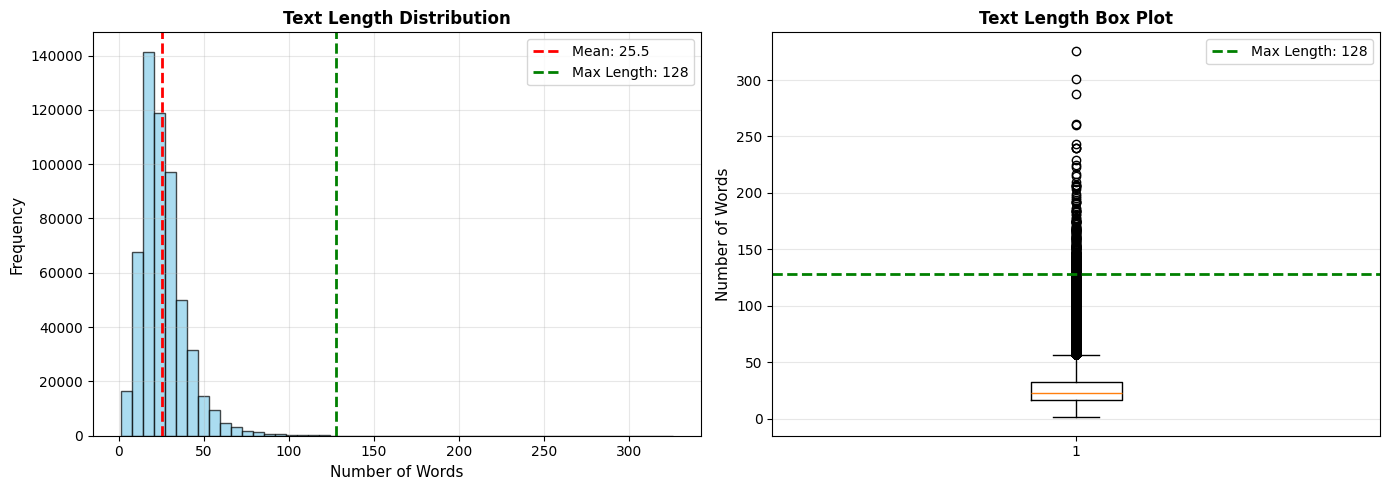


Text Length Statistics:
  Mean: 25.51 words
  Median: 23.00 words
  Max: 326 words
  Min: 1 words
  95th percentile: 50.00 words

0.0% of texts will be truncated at MAX_LENGTH=128


In [ ]:
# Analyze text lengths
text_lengths = [len(text.split()) for text in train_df['text']]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(text_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(text_lengths), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(text_lengths):.1f}')
axes[0].axvline(CONFIG['MAX_LENGTH'], color='green', linestyle='--',
                linewidth=2, label=f'Max Length: {CONFIG["MAX_LENGTH"]}')
axes[0].set_xlabel('Number of Words', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Text Length Distribution', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(text_lengths, vert=True)
axes[1].axhline(CONFIG['MAX_LENGTH'], color='green', linestyle='--',
                linewidth=2, label=f'Max Length: {CONFIG["MAX_LENGTH"]}')
axes[1].set_ylabel('Number of Words', fontsize=11)
axes[1].set_title('Text Length Box Plot', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nText Length Statistics:")
print(f"  Mean: {np.mean(text_lengths):.2f} words")
print(f"  Median: {np.median(text_lengths):.2f} words")
print(f"  Max: {max(text_lengths)} words")
print(f"  Min: {min(text_lengths)} words")
print(f"  95th percentile: {np.percentile(text_lengths, 95):.2f} words")

truncated_pct = (np.array(text_lengths) > CONFIG['MAX_LENGTH']).mean() * 100
print(f"\n{truncated_pct:.1f}% of texts will be truncated at MAX_LENGTH={CONFIG['MAX_LENGTH']}")

In [ ]:
# Custom PyTorch Dataset Implementation
class PubMedDataset(Dataset):
    """Custom PyTorch Dataset for PubMed abstracts"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Use __call__ instead of encode_plus (updated API)
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Step 3: **Model and Training Setup**

In [ ]:
class BERTClassifier(nn.Module):
    """
    BERT model for sequence classification.
    Optimized for speed and performance.
    """

    def __init__(self, num_classes=5, dropout=0.3):
        super(BERTClassifier, self).__init__()

        print("Loading BERT model...")
        # Load pre-trained BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        print("✓ BERT model loaded")

        # Dropout layer (MUST be nn.Dropout, not a float!)
        self.dropout = nn.Dropout(p=dropout)  # ← Fixed: added nn.Dropout()

        # Classification head
        self.fc = nn.Linear(768, num_classes)

        print("✓ Classifier initialized")

    def forward(self, input_ids, attention_mask):
        """Forward pass"""
        # Get BERT outputs
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Use pooled output (CLS token)
        pooled_output = outputs.pooler_output

        # Apply dropout
        pooled_output = self.dropout(pooled_output)

        # Classification
        logits = self.fc(pooled_output)

        return logits

In [ ]:
# Initialize tokenizer
print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
print("Creating PyTorch datasets...")
train_dataset = PubMedDataset(
    texts=train_df['text'].values,
    labels=train_df['label'].values,
    tokenizer=tokenizer,
    max_length=CONFIG['MAX_LENGTH']
)

val_dataset = PubMedDataset(
    texts=val_df['text'].values,
    labels=val_df['label'].values,
    tokenizer=tokenizer,
    max_length=CONFIG['MAX_LENGTH']
)

test_dataset = PubMedDataset(
    texts=test_df['text'].values,
    labels=test_df['label'].values,
    tokenizer=tokenizer,
    max_length=CONFIG['MAX_LENGTH']
)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset):,} samples")
print(f"  Val: {len(val_dataset):,} samples")
print(f"  Test: {len(test_dataset):,} samples")

Loading BERT tokenizer...
Creating PyTorch datasets...

Dataset sizes:
  Train: 560,035 samples
  Val: 14,466 samples
  Test: 14,746 samples


In [ ]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=True,
    num_workers=2,
    pin_memory=True  # Faster data transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['BATCH_SIZE'],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"DataLoader batches:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Val: {len(val_loader)} batches")
print(f"  Test: {len(test_loader)} batches")

# Estimate training time
steps_per_epoch = len(train_loader)
total_steps = steps_per_epoch * CONFIG['EPOCHS']
print(f"\nTraining steps:")
print(f"  Steps per epoch: {steps_per_epoch}")
print(f"  Total steps: {total_steps}")

DataLoader batches:
  Train: 17502 batches
  Val: 453 batches
  Test: 461 batches

Training steps:
  Steps per epoch: 17502
  Total steps: 52506


In [ ]:
# Initializing Model
model = BERTClassifier(num_classes=5, dropout=CONFIG['DROPOUT'])
model = model.to(device)
if CONFIG['FREEZE_BERT']:
  for param in model.bert.parameters():
    param.requires_grad = False
    print("BERT Layers Frozen")
else:
  print("Training All BERT Layers")

Loading BERT model...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ BERT model loaded
✓ Classifier initialized
Training All BERT Layers


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Frozen: {total_params - trainable_params:,}")
print(f"  Reduction: {(1 - trainable_params/total_params)*100:.1f}% fewer trainable params")


Model parameters:
  Total: 109,486,085
  Trainable: 109,486,085
  Frozen: 0
  Reduction: 0.0% fewer trainable params


## Loss and Optimizer:

In [ ]:
# Calculate class weights for imbalanced data
print("\nCalculating class weights...")
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label'].values),
    y=train_df['label'].values
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights:")
for i, name in enumerate(label_names):
    print(f"  {name:12s}: {class_weights[i]:.4f}")

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer (only optimize trainable parameters)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG['LEARNING_RATE'],
    eps=1e-8
)

print(f"\n✓ Optimizer: AdamW")
print(f"✓ Learning Rate: {CONFIG['LEARNING_RATE']}")
print(f"✓ Loss: Weighted CrossEntropyLoss")


Calculating class weights...
Class weights:
  BACKGROUND  : 1.0000
  CONCLUSIONS : 1.0000
  METHODS     : 1.0000
  OBJECTIVE   : 1.0000
  RESULTS     : 1.0000

✓ Optimizer: AdamW
✓ Learning Rate: 3e-05
✓ Loss: Weighted CrossEntropyLoss


# Step 4: **FineTuning**

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, scaler, use_amp=True):
    """
    Train model for one epoch with optional mixed precision.
    """
    model.train()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(train_loader, desc="Training", leave=True)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        if use_amp:
            # Mixed precision forward pass
            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

            # Mixed precision backward pass
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=CONFIG['GRADIENT_CLIPPING'])
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard forward/backward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=CONFIG['GRADIENT_CLIPPING'])
            optimizer.step()

        # Calculate metrics
        _, predictions = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(predictions == labels).item()
        total_samples += labels.size(0)
        total_loss += loss.item()

        # Update progress bar
        current_acc = correct_predictions / total_samples
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{current_acc:.4f}'
        })

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

In [ ]:
from torch.cuda.amp import GradScaler

scaler = GradScaler()

In [ ]:
import time

print("="*70)
print("STARTING TRAINING")
print("="*70)
print(f"Device: {device}")
print(f"Epochs: {CONFIG['EPOCHS']}")
print(f"Batch Size: {CONFIG['BATCH_SIZE']}")
print(f"Learning Rate: {CONFIG['LEARNING_RATE']}")
print(f"Mixed Precision: {CONFIG['USE_MIXED_PRECISION']}")
print("="*70)

# Storage for metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_accuracy = 0
best_model_state = None

# Start timer
start_time = time.time()

for epoch in range(CONFIG['EPOCHS']):
    epoch_start = time.time()

    print(f"\n{'='*70}")
    print(f"Epoch {epoch + 1}/{CONFIG['EPOCHS']}")
    print(f"{'='*70}")

    # Train
    train_loss, train_acc = train_model(
        model, train_loader, criterion, optimizer, device, scaler,
        use_amp=CONFIG['USE_MIXED_PRECISION']
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validate
    val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    epoch_time = time.time() - epoch_start

    # Print epoch summary
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"  Time: {epoch_time:.2f}s")

    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_state = model.state_dict().copy()
        print(f"  ✓ New best model! (Val Acc: {val_acc:.4f})")

    # Estimate remaining time
    if epoch < CONFIG['EPOCHS'] - 1:
        remaining_epochs = CONFIG['EPOCHS'] - epoch - 1
        estimated_time = epoch_time * remaining_epochs
        print(f"  Estimated time remaining: {estimated_time/60:.1f} minutes")

# Load best model
model.load_state_dict(best_model_state)

# Total training time
total_time = time.time() - start_time

print(f"\n{'='*70}")
print("TRAINING COMPLETED!")
print(f"{'='*70}")
print(f"Total training time: {total_time/60:.2f} minutes")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")
print(f"Average time per epoch: {total_time/CONFIG['EPOCHS']:.2f}s")
print(f"{'='*70}")

STARTING TRAINING
Device: cuda
Epochs: 3
Batch Size: 32
Learning Rate: 3e-05
Mixed Precision: True

Epoch 1/3


Evaluating: 100%|██████████| 453/453 [01:38<00:00,  4.59it/s, loss=0.8114, acc=0.8749]



Epoch 1 Summary:
  Train Loss: 0.4936 | Train Acc: 0.8044
  Val Loss:   0.3468 | Val Acc:   0.8749
  Time: 3678.90s
  ✓ New best model! (Val Acc: 0.8749)
  Estimated time remaining: 122.6 minutes

Epoch 2/3


Evaluating: 100%|██████████| 453/453 [01:38<00:00,  4.59it/s, loss=0.2667, acc=0.8773]



Epoch 2 Summary:
  Train Loss: 0.4252 | Train Acc: 0.8307
  Val Loss:   0.3484 | Val Acc:   0.8773
  Time: 3665.46s
  ✓ New best model! (Val Acc: 0.8773)
  Estimated time remaining: 61.1 minutes

Epoch 3/3


Evaluating: 100%|██████████| 453/453 [01:38<00:00,  4.58it/s, loss=0.2539, acc=0.8702]


Epoch 3 Summary:
  Train Loss: 0.3778 | Train Acc: 0.8498
  Val Loss:   0.3654 | Val Acc:   0.8702
  Time: 3670.55s

TRAINING COMPLETED!
Total training time: 183.58 minutes
Best validation accuracy: 0.8773
Average time per epoch: 3671.64s


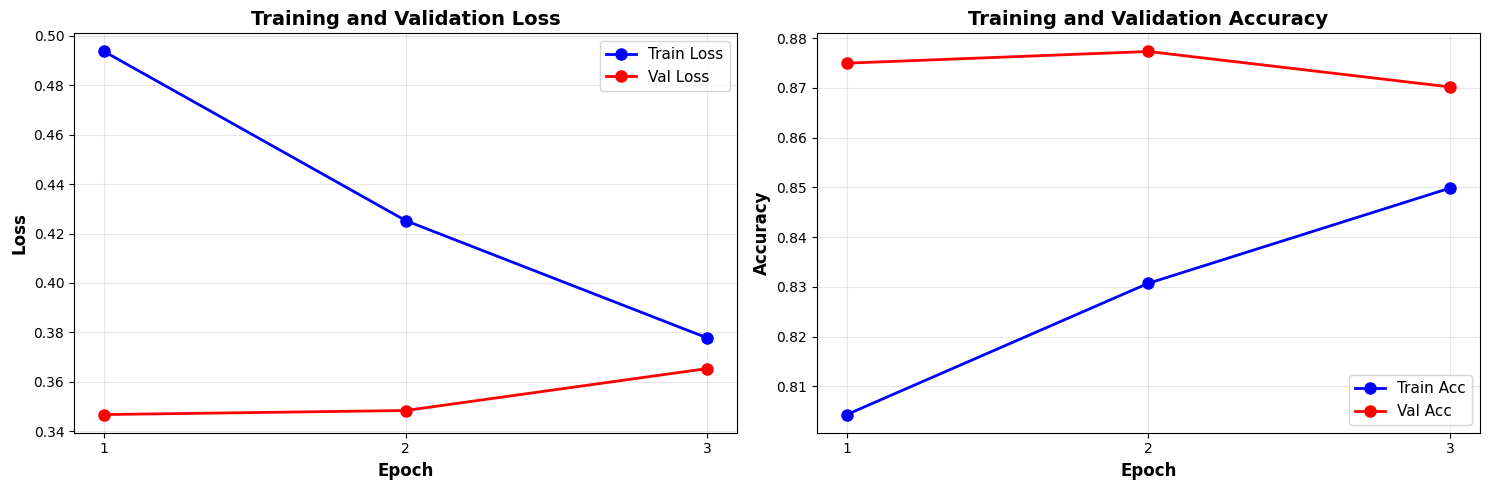


Training Summary:
------------------------------------------------------------
Epoch    Train Loss   Train Acc    Val Loss     Val Acc     
------------------------------------------------------------
1        0.4936       0.8044       0.3468       0.8749      
2        0.4252       0.8307       0.3484       0.8773      
3        0.3778       0.8498       0.3654       0.8702      
------------------------------------------------------------


In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, CONFIG['EPOCHS'] + 1)

# Loss plot
axes[0].plot(epochs_range, train_losses, 'bo-', label='Train Loss', linewidth=2, markersize=8)
axes[0].plot(epochs_range, val_losses, 'ro-', label='Val Loss', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(epochs_range)

# Accuracy plot
axes[1].plot(epochs_range, train_accuracies, 'bo-', label='Train Acc', linewidth=2, markersize=8)
axes[1].plot(epochs_range, val_accuracies, 'ro-', label='Val Acc', linewidth=2, markersize=8)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(epochs_range)

plt.tight_layout()
plt.show()

# Print summary table
print("\nTraining Summary:")
print("-" * 60)
print(f"{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12}")
print("-" * 60)
for i in range(CONFIG['EPOCHS']):
    print(f"{i+1:<8} {train_losses[i]:<12.4f} {train_accuracies[i]:<12.4f} "
          f"{val_losses[i]:<12.4f} {val_accuracies[i]:<12.4f}")
print("-" * 60)

# Step 5: **Evaluation**

In [ ]:
def evaluate_model(model, data_loader, criterion, device):
    """Evaluate model on validation/test set"""
    model.eval()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    progress_bar = tqdm(data_loader, desc="Evaluating", leave=True)

    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            # Get predictions
            _, predictions = torch.max(outputs, dim=1)

            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Calculate metrics
            correct_predictions += torch.sum(predictions == labels).item()
            total_samples += labels.size(0)
            total_loss += loss.item()

            # Update progress
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{correct_predictions/total_samples:.4f}'
            })

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy, all_predictions, all_labels

In [ ]:
print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70)

# Evaluate
test_loss, test_acc, test_predictions, test_labels = evaluate_model(
    model, test_loader, criterion, device
)

print(f"\nTest Set Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")


EVALUATING ON TEST SET


Evaluating: 100%|██████████| 461/461 [01:42<00:00,  4.51it/s, loss=0.3993, acc=0.8670]


Test Set Results:
  Loss: 0.3899
  Accuracy: 0.8670


In [ ]:
# Calculate all metrics
precision, recall, f1, support = precision_recall_fscore_support(
    test_labels,
    test_predictions,
    average='weighted'
)

print("\n" + "="*70)
print("FINAL EVALUATION METRICS (TEST SET)")
print("="*70)
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {precision:.4f} (weighted)")
print(f"Recall:    {recall:.4f} (weighted)")
print(f"F1-Score:  {f1:.4f} (weighted)")
print("="*70)


FINAL EVALUATION METRICS (TEST SET)
Accuracy:  0.8670
Precision: 0.8735 (weighted)
Recall:    0.8670 (weighted)
F1-Score:  0.8683 (weighted)


In [ ]:
# Detailed per-class metrics
print("\nDetailed Classification Report:")
print("="*70)
report = classification_report(
    test_labels,
    test_predictions,
    target_names=label_names,
    digits=4
)
print(report)


Detailed Classification Report:
              precision    recall  f1-score   support

  BACKGROUND     0.6199    0.8104    0.7025      1340
 CONCLUSIONS     0.8187    0.8313    0.8250      2217
     METHODS     0.9350    0.9289    0.9319      4893
   OBJECTIVE     0.7721    0.6235    0.6899      1190
     RESULTS     0.9285    0.8948    0.9113      5106

    accuracy                         0.8670     14746
   macro avg     0.8148    0.8178    0.8121     14746
weighted avg     0.8735    0.8670    0.8683     14746



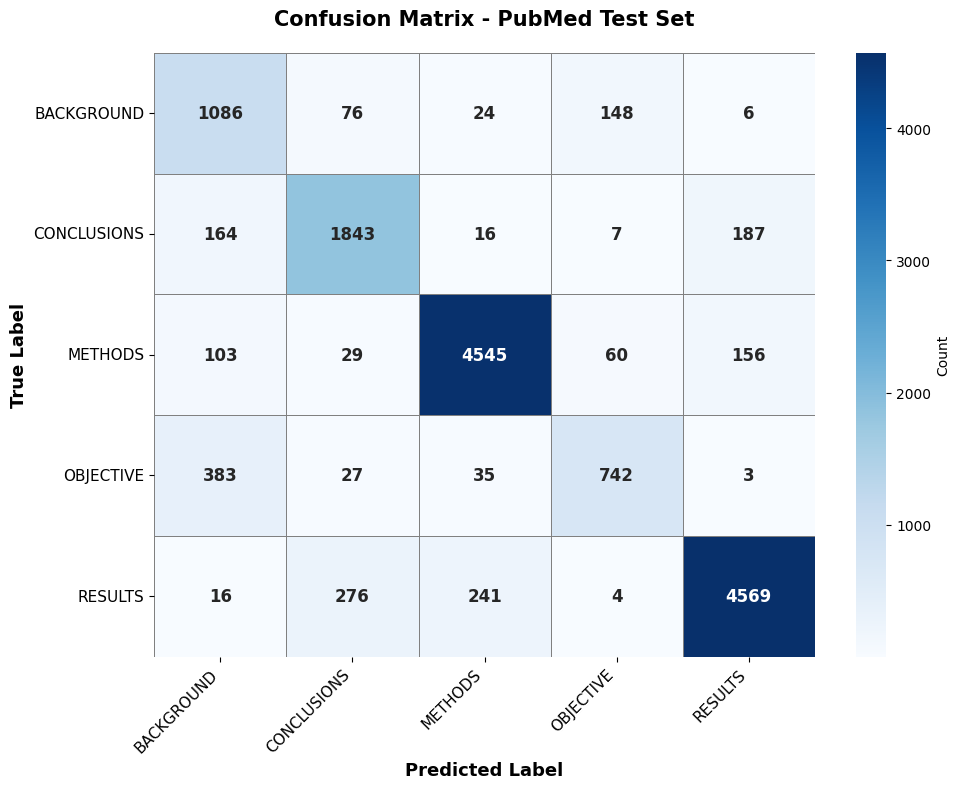


Confusion Matrix Analysis:
------------------------------------------------------------
BACKGROUND  : 1086/1340 correct (81.04%) |  254 errors
CONCLUSIONS : 1843/2217 correct (83.13%) |  374 errors
METHODS     : 4545/4893 correct (92.89%) |  348 errors
OBJECTIVE   :  742/1190 correct (62.35%) |  448 errors
RESULTS     : 4569/5106 correct (89.48%) |  537 errors
------------------------------------------------------------


In [ ]:
# Create and plot confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names,
    cbar_kws={'label': 'Count'},
    linewidths=0.5,
    linecolor='gray',
    annot_kws={'size': 12, 'weight': 'bold'}
)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.title('Confusion Matrix - PubMed Test Set', fontsize=15, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

# Analyze confusion matrix
print("\nConfusion Matrix Analysis:")
print("-" * 60)
for i, label in enumerate(label_names):
    correct = cm[i, i]
    total = cm[i].sum()
    accuracy = correct / total if total > 0 else 0
    errors = total - correct
    print(f"{label:12s}: {correct:4d}/{total:4d} correct ({accuracy:6.2%}) | {errors:4d} errors")
print("-" * 60)

# Step 6: **Inference**


In [ ]:
# ============================================================
# INFERENCE FUNCTION - FIXED
# ============================================================

def predict_text(text, model, tokenizer, device, label_names, max_length=128):
    """
    Predict class and confidence for input text.

    Args:
        text: Input medical abstract sentence
        model: Trained BERT model
        tokenizer: BERT tokenizer
        device: torch device
        label_names: List of class names
        max_length: Max sequence length

    Returns:
        dict with prediction results
    """
    model.eval()

    # Tokenize
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Handle both HuggingFace model (has .logits) and custom model (returns tensor)
        if hasattr(outputs, 'logits'):
            logits = outputs.logits
        else:
            logits = outputs  # Custom BERTClassifier returns tensor directly

        probabilities = torch.softmax(logits, dim=1)[0]
        confidence, predicted_class = torch.max(probabilities, dim=0)

    predicted_label = label_names[predicted_class.item()]
    confidence_score = confidence.item() * 100

    # Get all probabilities
    all_probs = {
        label_names[i]: probabilities[i].item() * 100
        for i in range(len(label_names))
    }

    return {
        'text': text,
        'predicted': predicted_label,
        'confidence': confidence_score,
        'probabilities': all_probs
    }


def print_prediction(result):
    """Pretty print prediction result"""
    print("="*80)
    print(f"TEXT: {result['text'][:150]}{'...' if len(result['text']) > 150 else ''}")
    print("-"*80)
    print(f"PREDICTED: {result['predicted']}")
    print(f"CONFIDENCE: {result['confidence']:.1f}%")
    print("-"*80)
    print("ALL PROBABILITIES:")

    # Sort by probability
    sorted_probs = sorted(result['probabilities'].items(), key=lambda x: x[1], reverse=True)

    for label, prob in sorted_probs:
        bar = '█' * int(prob / 2)
        marker = ' <- PREDICTED' if label == result['predicted'] else ''
        print(f"  {label:12s}: {prob:5.1f}% {bar}{marker}")

    print("="*80)
    print()

In [ ]:
# Testing Inference Pipeline
# Test examples (one from each class)
test_examples = [
    {
        'text': "Previous research has demonstrated that obesity is strongly associated with type 2 diabetes and cardiovascular disease in adult populations worldwide.",
        'expected': 'BACKGROUND'
    },
    {
        'text': "The primary aim of this randomized controlled trial was to evaluate the efficacy and safety of a novel insulin analog in patients with poorly controlled type 2 diabetes.",
        'expected': 'OBJECTIVE'
    },
    {
        'text': "A total of 500 participants aged 18-65 years were randomly assigned to either the intervention group or the control group using computer-generated random numbers.",
        'expected': 'METHODS'
    },
    {
        'text': "The intervention group demonstrated a mean HbA1c reduction of 1.8% compared to 0.4% in the control group (p<0.001), with no significant difference in adverse events.",
        'expected': 'RESULTS'
    },
    {
        'text': "These findings suggest that the novel insulin analog is both effective and well-tolerated, and may represent a valuable treatment option for patients with inadequately controlled diabetes.",
        'expected': 'CONCLUSIONS'
    }
]

# Run predictions
correct = 0
total = len(test_examples)

for i, example in enumerate(test_examples, 1):
    print(f"\n{'EXAMPLE ' + str(i):.^80}")
    print(f"Expected Class: {example['expected']}\n")

    # Predict
    result = predict_text(
        example['text'],
        model,
        tokenizer,
        device,
        label_names,
        max_length=CONFIG.get('MAX_LENGTH', 128)
    )

    # Print result
    print_prediction(result)

    # Check if correct
    if result['predicted'] == example['expected']:
        correct += 1
        print("[CORRECT]\n")
    else:
        print(f"[WRONG] Expected: {example['expected']}\n")

# Summary
print(f"INFERENCE TEST SUMMARY".center(80))
print(f"Correct Predictions: {correct}/{total} ({correct/total*100:.1f}%)")


...................................EXAMPLE 1....................................
Expected Class: BACKGROUND

TEXT: Previous research has demonstrated that obesity is strongly associated with type 2 diabetes and cardiovascular disease in adult populations worldwide.
--------------------------------------------------------------------------------
PREDICTED: BACKGROUND
CONFIDENCE: 69.7%
--------------------------------------------------------------------------------
ALL PROBABILITIES:
  BACKGROUND  :  69.7% ██████████████████████████████████ <- PREDICTED
  OBJECTIVE   :  29.7% ██████████████
  CONCLUSIONS :   0.6% 
  METHODS     :   0.1% 
  RESULTS     :   0.0% 

[CORRECT]


...................................EXAMPLE 2....................................
Expected Class: OBJECTIVE

TEXT: The primary aim of this randomized controlled trial was to evaluate the efficacy and safety of a novel insulin analog in patients with poorly controll...
--------------------------------------------------

# **Save Model**

In [ ]:
# !git clone https://github.com/PreethamVJ/LangrangersFinetuningBert

In [ ]:
path = "/content/LangrangersFinetuningBert"

In [ ]:
import os

# Create models directory
models_dir = f"{path}/saved_models"
os.makedirs(models_dir, exist_ok=True)

# Save the complete model
final_model_path = os.path.join(models_dir, "pubmed_bert_final.pt")

torch.save({
    'epoch': CONFIG['EPOCHS'],
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': CONFIG,
    'label_names': label_names,
    'best_val_accuracy': best_val_accuracy,
    'test_accuracy': test_acc,
    'test_precision': precision,
    'test_recall': recall,
    'test_f1': f1,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
}, final_model_path)

In [ ]:
print("MODEL SAVED SUCCESSFULLY")
print(f"Location: {final_model_path}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1-Score: {f1:.4f}")
print("="*70)

# Also save just the model weights (smaller file)
weights_path = os.path.join(models_dir, "pubmed_bert_weights.pt")
torch.save(model.state_dict(), weights_path)
print(f"Weights only: {weights_path}")

MODEL SAVED SUCCESSFULLY
Location: /content/LangrangersFinetuningBert/saved_models/pubmed_bert_final.pt
Test Accuracy: 0.8670
F1-Score: 0.8683
Weights only: /content/LangrangersFinetuningBert/saved_models/pubmed_bert_weights.pt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')